https://www.kaggle.com/competitions/imagenet-object-localization-challenge/data

In [1]:
# !kaggle competitions download -c imagenet-object-localization-challenge

100%|███████████████████████████████████████▉| 155G/155G [44:52<00:00, 67.2MB/s]
100%|████████████████████████████████████████| 155G/155G [44:52<00:00, 61.8MB/s]


# Imagenet

In [67]:
import os 
from glob import glob 
from pathlib import Path
import pandas as pd
import random
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm

base_path = Path('data/ILSVRC')
path = Path(base_path / 'Data/CLS-LOC/')

In [55]:
splits = os.listdir(path)
splits

['test', 'val', 'train']

In [59]:
classes = sorted(os.listdir(path/'train'))
assert len(classes) == 1000
# assert len(classes) == os.listdir(path/'test')
# assert len(classes) == os.listdir(path/'val')
val_images = os.listdir(path/'val')

len(classes), len(val_images), len(os.listdir(path/'test'))

(1000, 50000, 100000)

Para train tenemos 1000 carpetas, y dentro de cada una los ejemplos. Podemos usar el nombre de la carpeta como etiqueta. En val/test sin embargo tenemos la lista de todas las imágenes pero no sabemos a qué clase pertenecen. Para val tendremos que sacarla de los archivos xml.

In [60]:
images, labels = [], []
for i, c in enumerate(classes):
	this_images = glob(str(path/'train'/c/'*.JPEG'))
	images += this_images
	labels += [i] * len(this_images)
train = pd.DataFrame({'image': images, 'label': labels})
train

,image,label
0,data/ILSVRC/Data/CLS-LOC/train/n01440764/n0144...,0
1,data/ILSVRC/Data/CLS-LOC/train/n01440764/n0144...,0
2,data/ILSVRC/Data/CLS-LOC/train/n01440764/n0144...,0
3,data/ILSVRC/Data/CLS-LOC/train/n01440764/n0144...,0
4,data/ILSVRC/Data/CLS-LOC/train/n01440764/n0144...,0
...,...,...
1281162,data/ILSVRC/Data/CLS-LOC/train/n15075141/n1507...,999
1281163,data/ILSVRC/Data/CLS-LOC/train/n15075141/n1507...,999
1281164,data/ILSVRC/Data/CLS-LOC/train/n15075141/n1507...,999
1281165,data/ILSVRC/Data/CLS-LOC/train/n15075141/n1507...,999


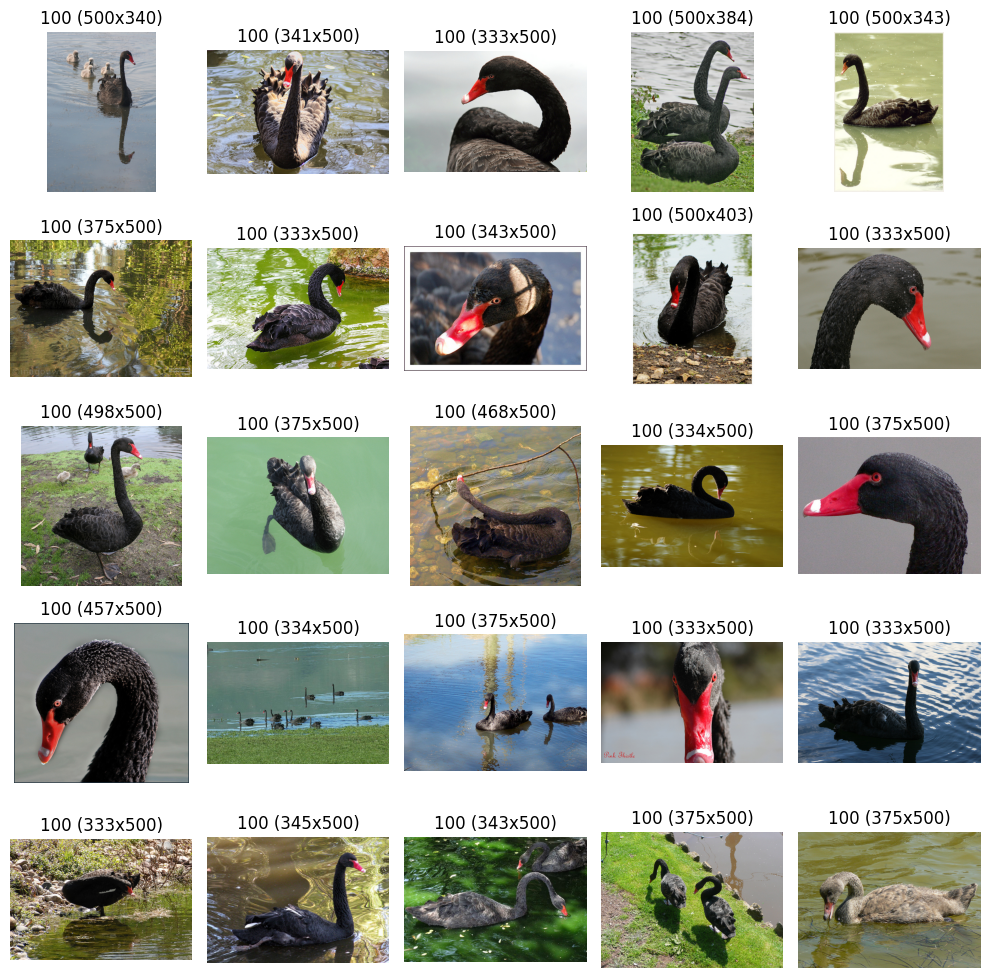

In [71]:
# plot samples

def plot_samples(df, label=100):
	samples = df[df.label == label].sample(25)
	# samples = df.sample(25)
	fig = plt.figure(figsize=(10, 10))
	r, c = 5, 5
	for i in range(r * c):
		ax = fig.add_subplot(r, c, i + 1)
		img = plt.imread(samples.iloc[i]['image'])
		plt.imshow(img)
		plt.axis('off')
		h, w = img.shape[:2]
		plt.title(f'{samples.iloc[i]["label"]} ({h}x{w})')
	plt.tight_layout()
	plt.show()

plot_samples(train)

In [62]:
val_annotations = glob(str(base_path/'Annotations/CLS-LOC/val/*.xml'))
assert len(val_annotations) == len(val_images)

In [79]:

val_images, val_labels = [], []
for ann in tqdm(val_annotations):
    # read xml
	tree = ET.parse(ann)
	root = tree.getroot()
	cls = root.findall('object')[0].find('name').text
	val_labels.append(classes.index(cls))
	val_images.append(path/'val'/f'{ann.split("/")[-1].split(".")[0]}.JPEG')

val = pd.DataFrame({'image': val_images, 'label': val_labels})
val

100%|██████████| 50000/50000 [00:02<00:00, 22542.37it/s]


,image,label
0,data/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00...,796
1,data/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00...,936
2,data/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00...,712
3,data/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00...,202
4,data/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00...,419
...,...,...
49995,data/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00...,379
49996,data/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00...,787
49997,data/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00...,387
49998,data/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00...,7


In [80]:
assert len(val.label.unique()) == len(classes)

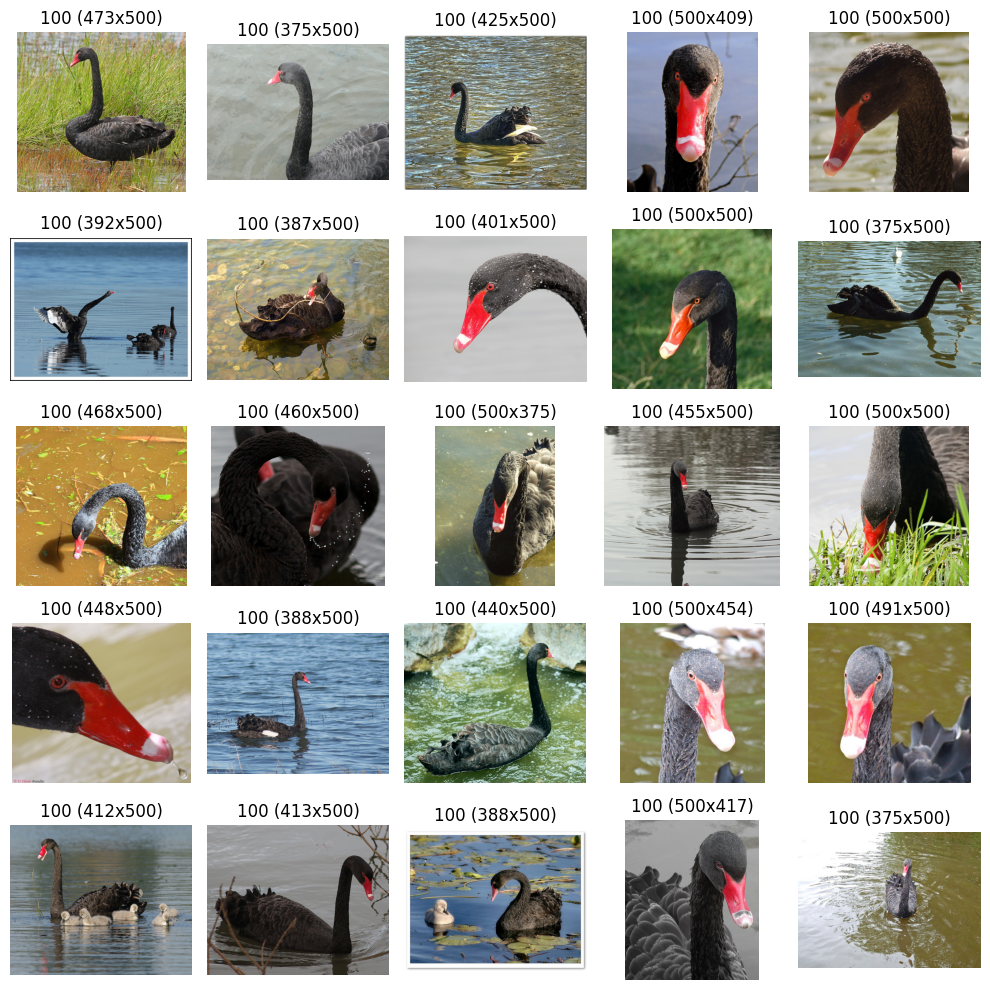

In [81]:
plot_samples(val)

Parece que sí...

Most models are trained on scaled versions of these images. To accelerate training we are going to resize them so the smallest side is 256 pixels and then take a center crop of size 256x256 and save them in a new directory.

In [53]:
len(val_annotations)

0

In [ ]:
def resize_and_crop(im):
    w, h = im.size
	if w == h: return im
	if w > h: return im.crop(((w-h)//2, 0, (w+h)//2, h))
	return im.crop((0, (h-w)//2, w, (h+w)//2))